In [1]:
import random
import daft
import queue
import networkx as nx
from time import *
from pgmpy.base import DAG
import matplotlib.pyplot as plt
from itertools import chain

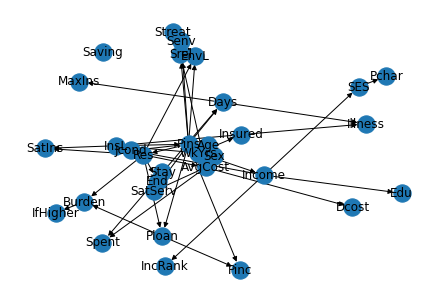

In [2]:
G = nx.DiGraph()

G.add_nodes_from(["Pins", "End","Res","Stay","Insured","Edu","SES","Illness","Jcond","EnvL","Burden","SatIns","SatServ","IfHigher",
                  "IncRank","AvgCost","InsL","Spent","Pinc","Pchar","Ploan","Dcost","Streat","Srel","Senv","Sex","Days","MaxIns",
                  "WkYrs","Income","Saving","Age"])

G.add_edges_from([("Age", "WkYrs"), ("WkYrs", "Insured"),("Sex", "WkYrs"), ("WkYrs", "Income"), ("Income", "Edu"),
                  ("Income", "IncRank"),("Income", "SES"), ("Insured", "InsL"),("WkYrs", "InsL"), ("WkYrs", "Pins"),
                 ("InsL", "Pins"), ("SES", "Pchar"),("Income", "Jcond"), ("Pins", "Jcond"),("Jcond", "Res"), 
                  ("Pins", "Res"),("Res", "EnvL"), ("Pins", "EnvL"),("InsL", "SatIns"), ("Res", "SatIns"),
                 ("Pins", "AvgCost"), ("Res", "AvgCost"),("Pins", "Ploan"), ("Res", "Ploan"),("Ploan", "Burden"), 
                  ("Res", "Burden"),("Pins", "SatServ"), ("AvgCost", "SatServ"),("Ploan", "Pinc"), ("Pins", "Pinc"),
                 ("AvgCost", "Dcost"), ("AvgCost", "Srel"),("Pins", "Senv"), ("Pins", "Srel"),("EnvL", "Senv"), 
                  ("SatServ", "End"),("Burden", "IfHigher"), ("Res", "End"), ("Srel", "Streat"), ("Senv", "Streat"),
                 ("End", "Stay"), ("Stay", "Spent"), ("Pins", "Days"), ("AvgCost", "Spent"),("Stay", "Days"), 
                  ("Insured", "Illness"),("Days", "Illness"), ("Days", "MaxIns")])
nx.draw(G,with_labels = True)

In [3]:
def An(g, source): 
    G_pred = g.pred
    seen = set()
    nextlevel = source
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G_pred[v])
    return seen

In [4]:
def Pass(e,u,f,v,Re,An_Re): 
    if u not in An_Re: 
        if e == 0 and f == 1:
            return False
        else:
            return True
    elif u in Re:
        if e == 0 and f == 1:
            return True
        else:
            return False
    else:
        return True

In [5]:
def Rech(g, source, Re):    
    An_Re = An(g, Re) 
    Q = []
    P = set()
    for ch in set(G.successors(source)):
        Q.append((0,ch))
        P.add((0,ch))
    for pa in set(G.predecessors(source)):
        Q.append((1,pa))
        P.add((1,pa))
    while Q:
        eV = Q.pop(0)
        for ch in set(G.successors(eV[1])):
            if (0,ch) not in P and Pass(eV[0],eV[1],0,ch,Re,An_Re):
                Q.append((0,ch))
                P.add((0,ch))
        for pa in set(G.predecessors(eV[1])):
            if (1,pa) not in P and Pass(eV[0],eV[1],1,pa,Re,An_Re):
                Q.append((1,pa))
                P.add((1,pa))
    reachable = {item[1] for item in P}
    return reachable

In [6]:
def FCMS(g,u,v):
    
    An = nx.subgraph(g, nx.ancestors(g, u) | nx.ancestors(g, v)|{u,v})
    mb_u = set([parent for child in An.successors(u) for parent in An.predecessors(child)]) | set(An.successors(u)) | set(An.predecessors(u))
    mb_u.discard(u)
    reach_v = Rech(g, v, mb_u)
    return mb_u & reach_v

In [7]:
def CMDSA(g,r):
    ang = nx.subgraph(g, An(g, r))
    h = r
    s = 1
    mark = set()
    while s:
        s = 0
        Q = set()
        m = set(G.nodes)-h
        mb = nx.node_boundary(g, m, h)
        h_ch_in_m = nx.node_boundary(g, h, m)
        for v in mb:
            pa = set(g.predecessors(v))
            Q |= (pa & h)
        for v in h_ch_in_m:
            Q |= (h & set(g.predecessors(v)))
        Q |= mb
        if len(Q)>1:
            for a in Q.copy():
                Q.remove(a)
                for b in Q:                    
                    if (a,b) not in mark and g.has_edge(a, b)==False: 
                        mark.add((a,b))
                        mark.add((b,a))
                        if g.has_edge(b,a)==False: 
                            S_a = FCMS(ang,a,b)                           
                            if not S_a:
                                continue
                            S_b = FCMS(ang,b,a)
                            if ( S_a | S_b) - (( S_a | S_b) & h):
                                s = 1
                                h |= ( S_a | S_b)  
                            break               
            else:
                continue
            break

    return h
    

In [11]:
R = ["Burden","Pins","Res","SatServ"]

An(G,R),CMDSA(G,set(R)),len(An(G,R))-len(CMDSA(G,set(R)))

({'Age',
  'AvgCost',
  'Burden',
  'Income',
  'InsL',
  'Insured',
  'Jcond',
  'Pins',
  'Ploan',
  'Res',
  'SatServ',
  'Sex',
  'WkYrs'},
 {'AvgCost', 'Burden', 'Pins', 'Ploan', 'Res', 'SatServ'},
 7)